# 070 Classification with Scikit Learn

> COM6018

*Copyright &copy; 2023, 2024 Jon Barker, University of Sheffield. All rights reserved*.


## Introduction

In this lab class we will be using Scikit Learn to build a face classification system.

We will be using another of Scikit Learn's builtin data sets, the 'Labeled faces in the Wild' face recognition dataset. This dataset is a collection of pictures of famous people gathered from the internet. It contains 13233 images of 5749 famous people. For some people there are many examples (e.g., 530 images of George W. Bush). For other people there are only a few (e.g., 2 images of Donald Rumsfeld). The faces are all labeled with the person's identity. More details can be found at http://vis-www.cs.umass.edu/lfw/.

We will be using a subset of the data, namely, the people who are represented by at least 50 images in the database. This will give us a dataset of 12 people and 1560 images in total. We will then treat this as a 12 class classification problem, i.e., given one of the images, which of the 12 people is it?


## Step 1 - Loading and viewing the data

To load the data run the cell below which loads the data and also resizes the images to 37 pixels wide by 50 pixels high. (Note, the first time this is run it may take a few minutes to complete. You can use this time to read the rest of this notebook.)


In [1]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.4)


The returned data is stored in `lfw_people` which is a dictionary-like object with the following keys: 
- `data` - the list of feature vectors, one per image, 
- `images` - the list of 37 by 50 pixel images,
- `target` - the list of labels for the images, i.e., the identity of the person in each image,
- `target_names` - the set of labels, i.e., the names of the 12 people in the images,
- `DESCR` - a string describing the dataset.

Use the cell below to print the DESCR field. Read the description and make sure you understand it.


In [26]:
print(lfw_people.data.shape)
#1560 amount 

print(lfw_people.DESCR)

(1560, 1850)
.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in 

The images field contains the list of images, i.e. one image per sample, with each image stored as a 2-D NumPy array. We can display these using the `imshow` method of `matplotlib.pyplot`. 

In the cell below, import `matplotlib.pyplot`` and use it to show the first 16 images in the dataset arranged as a 4 by 4 grid of images.

Hint: You can use `plt.axis('off')` to avoid displaying the axes and tick marks.

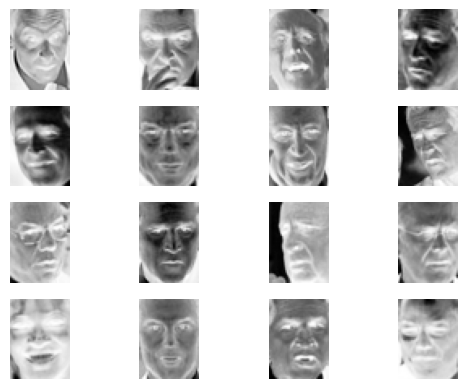

In [52]:
# WRITE SOLUTION HERE
import matplotlib.pyplot as plt

#print(lfw_people.get('images'))
for i in range(16): 
    plt.subplot(4, 4, i +1) 
    plt.imshow(lfw_people.get('images')[i], cmap='Greys')  
    plt.axis('off')

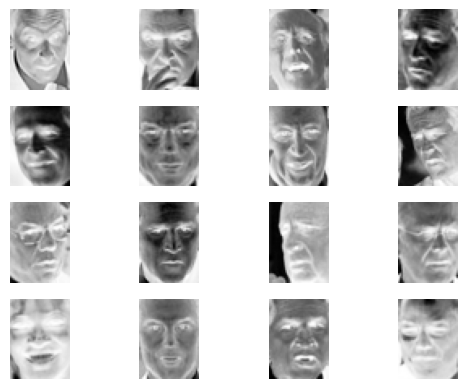

In [37]:
import matplotlib.pyplot as plt 

for index in range(16):
    plt.subplot(4, 4, index + 1)
    plt.imshow(lfw_people.get('images')[index], cmap='Greys')
    plt.axis('off')


## Step 2 - Splitting the data into training and test sets

Following the approaches used in the previous lab class and tutorial, split the data into training and test sets. Use 75% of the data for training and 25% for testing. Store the training data as the variable, `X_train`, and the test data as `X_test`. The training labels should be named `y_train` and the test labels, `y_test`.

Use `random_state=0` to ensure that the data is split in the same way each time the code is run.

Write the code in the cell below and check that the training and test sets have the correct sizes by running the test cell.


In [10]:
# WRITE SOLUTION HERE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(lfw_people.data, lfw_people.target, test_size=0.25, random_state=0)

In [11]:
# TEST
print(X_test.shape)
assert X_train.shape == (1170, 1850)
assert X_test.shape == (390, 1850)
assert y_train.shape == (1170,)
assert y_test.shape == (390,)
print("All tests passed!")

(390, 1850)
All tests passed!


## Step 3 - Using a KNN classifier

We will start by using the KNN classifier that we introduced in the previous lab class.

In the cell below, import the `KNeighborsClassifier` from `sklearn.neighbors` and create a classifier that uses 1 neighbour. Train the classifier on the training data and labels. Then use the classifier to predict the labels for the test data. Call the predicted labels `y_pred`.

Score the classifier by calculating the accuracy on the test data and labels. Finally print the accuracy.



In [14]:
# WRITE SOLUTION HERE
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=1)

In [15]:
from sklearn import metrics
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.5025641025641026


You should get an accuracy of about 50.2%.

Now, use the `GridSearchCV` class to find the best value of k for the KNN classifier. Test all odd values of k from 1 to 21. Use 5-fold cross validation.

In [57]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_neighbors': range(1, 22,2)}

knn = KNeighborsClassifier()
model = GridSearchCV(knn, parameters, cv=5)
model.fit(X_train, y_train)
print(model.best_params_)


{'n_neighbors': 11}


You should find that with a value of k=11 you get an accuracy of about 51.8%, i.e., a little better than when k=1.

However, this is still not very good. We can do better by using a more sophisticated classifier but we may also be able to improve performance by representing the images in a different way.

One of the problems here is that the feature vector has 1850 dimensions (i.e., a separate value for every pixel). This is a lot of dimensions for a KNN classifier to work with and it can result in a problem known as `overfitting`. In the next section we will reduce the number of features by using a `dimensionality reduction` technique to transform the feature vector into a lower dimensional space.

## Step 4 - Applying a dimensionality reduction technique

Our samples are described by the values of 1850 pixels. Many of these pixels are irrelevant to the task, e.g., pixels in the corners of the image which capture information about the background. Also, many of the pixels are highly correlated with each other, e.g., neighbouring pixels will have similar values, meaning that there is a lot of `redundancy` in the data. It is generally easier to train a classifier if we can describe our samples using a smaller number of features, and using features that are not highly correlated with each other. 

Fortunately, there are very powerful and easy-to-implement approaches that can be used to learn a  `transform` that can reduce a high-dimensional feature vector into a lower-dimensional one. These are called `dimensionality reduction` techniques. They are a very important part of machine learning and we will be looking at them in more detail later in the module. For now we will just use one of these techniques, called `Principal Component Analysis` (PCA) and see how it can be applied in SciKit Learn.


### Step 4.1 - Standardising the data

Before using PCA we will first `standardise` the data. i.e., apply a scaling and offset to each feature so that all features have a mean of zero and a variance of one. This can be done using the `StandardScaler` class from `sklearn.preprocessing` module. See the example in the tutorial notes and write the necessary code below.  

Note, you should `fit` the transform using the `X_train` data and apply the same transform to both the `X_train` and `X_test` data. Store the results as `X_train_scaled` and `X_test_scaled` respectively. You should use the `fit_transform` and `transform` methods.


In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#print(X_train_scaled)

[[-0.8642163  -0.6055848   0.42202193 ...  0.56669253 -0.68187135
  -0.94846165]
 [-0.43072182 -0.17311072  1.268373   ...  1.7566698   0.9971713
  -0.7924905 ]
 [ 0.70358866  0.39357945  0.8795091  ...  0.8533294   0.83580875
   0.8365414 ]
 ...
 [-1.0014896  -1.0231462  -1.1334338  ...  1.46569     1.5772041
   1.7333755 ]
 [-0.5174207  -0.5608461  -0.91231513 ... -1.1922157  -1.2575431
  -1.1217629 ]
 [-1.4277592  -1.2468396  -1.2096816  ... -0.86649203 -1.0002353
  -0.8314833 ]]


### Step 4.2 - Applying PCA

The PCA technique learns a specific dimensionality reducing transform from the training data features (in Scikit-Learn this stage is called 'fitting'). Once a transform has been learnt it can then be applied to the training and test data to produce the new lower-dimensioned feature vectors. 

We will now perform the PCA fitting and transforming steps in the cell below. This can be done using the `PCA` class that can be imported from `sklearn.decompostion`. This can be used in a very similar way to the `StandardScaler` class, i.e., using methods called `fit_transform` and `transform`. The PCA class has a parameter called `n_components` that can be used to specify the number of features that we want for the output. Set this to 200. 

Note, remember to use the `X_train_scaled` data to learn the PCA transform. Store the transformed data in the variable `X_test_pca` and `X_train_pca`.

Write the solution below and run the test cell to check that your data looks correct.

In [72]:
# WRITE SOLUTION HERE

from sklearn.decomposition import PCA
pca = PCA(n_components=200)
pca.fit_transform(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(X_train_pca.shape)

(1170, 200)


In [67]:
# TEST
assert X_test_pca.shape == (390, 200)
assert X_train_pca.shape == (1170, 200)
print('All tests passed!')

All tests passed!


### Step 4.3 - Evaluating the reduced feature vector

We will now repeat the KNN classification but this time we will use the `X_train_pca` and `X_test_pca` feature vectors instead of the original `X_train` and `X_test` feature vectors. Note, the optimal value of k may now have changed, so rerun a grid search with the `X_train_pca` and using 5-fold cross-validation as before.

In [74]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_neighbors': range(1, 22,2)}

knn = KNeighborsClassifier()
model = GridSearchCV(knn, parameters, cv=5)
model.fit(X_train_pca, y_train)
print(model.best_params_)


{'n_neighbors': 5}


The result should now be slightly better than before. When I ran this I got a score of 54.6% correct with the optimum value of k being 5. This is a little better than the 51.7% that we got before using the original feature vectors.

## Step 5 - Using a `pipeline`` to combine feature extraction and classification

In the previous steps, we have seen how to use Scikit-Learn to standardise data, perform dimensionality reduction, tune hyperparameters and then perform classification. The data pre-processing and classification steps were performed separately. This is not ideal as it can lead to errors. For example, we end up with multiple different versions of the data, e.g. X_train, X_train_scaled, X_train_pca, and similarly for the test data, so it would be very easy to get these variables confused. In this section we are going to use a construct called a 'pipeline' to combine the feature extraction and classification steps into a single stage.

Review the material in the tutorial notes to see how to use a pipeline. Then, create a pipeline that combines the StandardScaler transform, the PCA transform with the number of components set to 200 and the KNN classifier with the number of neighbours set to 5.

Store the pipeline as a variable called `pipeline`. Run the `fit` method with `X_train` on the pipeline and then the `score` method with `X_test` and `y_test`. 

What is the accuracy? It should be the same as the accuracy that you got in the previous step. The pipeline does not change the computation, it just makes it easier to manage.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])
rf_pipeline.fit(X_train, y_train)
score = rf_pipeline.score(X_test, y_test)
print(score)

The pipeline can itself be used with the GridSearchCV class in order to tune its hyperparameters. Using GridSearchCV with a pipeline is just the same as using it with one of the builtin models. The only thing to note is that the parameter names have the form <step_name>__<parameter_name>. For example, if the KNeighborsClassifier step of the pipeline has been called `knn`, then to tune its `n_neighbors` parameter we would refer to the parameter as `knn__n_neighbors`.

Write code to tune the pipelines `n_neighbour` parameter and then evaluate the resulting model using the `X_test` data.

Note, if we search for values of k from 1 to 21 as we did before, then the GridSearch will take quite a long time to run (several minutes on my macbook pro). Just use k values of 1,3,5 and 7 in the grid search so that you don't have to wait too long.

Write your solution below.

The reason that the GridSearch is slow is that it is re-running the entire pipeline for every value of k that it is testing. This means that the computationally expensive PCA fitting step is getting run many times. This is inefficient because the PCA step is part of the data pre-processing and will be the same for every value of k used by the classifier.  

To avoid the recomputation, you can use sklearn's 'caching' mechanism that is part of the `Memory` module in the `joblib` package. See the tutorial notes for an example of how to do this. Implement it below and now retry the search using odd values of k from 1 to 21 again.

In [ ]:
# WRITE SOLUTION HERE

## Step 6 - Experimenting with different classifiers

Now that we have a pipeline for training and evaluating classifiers, we can easily experiment with different classifiers. We will try the following classifiers:

- Random Forests
- Support Vector Machines (SVM)
- Neural Network

For each one, we will use the techniques used previously to tune hyperparameters before evaluating the classifier on the test set.


### Step 6.1 - Using a Random Forest Classifier

We will now replace the KNearestNeighbour classifier with a Random Forest classifier. The pipeline should again start with the StandardScalar and PCA transforms but the classifier at the end of the pipeline will be changed. The Random Forest classifier is provided by the `RandomForestClassifier` class in the `sklearn.ensemble` module.

The Random Forest classifier has many hyperparameters but one of the most important is the number of trees in the forest, which is specified by the parameter `n_estimators`.

For the GridSearch, search over both the number of trees and the number of PCA components. Use values of 10, 50 and 100 for the number of tree. Use values of 20, 50 and 100 for the number of PCA components. Use a cache to speed up the search. Also, when constructing the GridSearchCV object, set the `n_jobs` parameter to -1. This instructs the GridSearchCV to use all available cores to perform the search. Depending on your computer, this may provide a significant speed up (on my Macbook Pro, using all the cores makes the processing about 8 times faster).

In [ ]:
# WRITE SOLUTION HERE

What is the final accuracy? When I ran this, I got a score of 56.7%, i.e., significantly better than the best score achieved with the KNN classifier (54.6%).

### Step 6.2 - Using a Support Vector Machine (SVM) Classifier

We will now use a Support Vector Machine (SVM) classifier. Again this should require just a minor edit to the previous code. The pipeline should again start with the StandardScalar and PCA transforms but the classifier on the end will be changed. The SVM classifier is provided by the `sklearn.svm.SVC` class. 

The key parameter for the SVC is the kernel, which is specified by the parameter `kernel`. The kernel is specified using a string and can be one of `linear`, `poly`, `rbf` or `sigmoid`. The SVC also has a parameter called C that controls the amount of regularisation. The default value of C is 1.0.

For the GridSearch, search over the kernel type, the C parameter and the number of PCA components. Use values of `linear`, `poly`, `rbf` and `sigmoid` for the kernel and values of 0.5, 1.0 and 2.0 for C. SVM work well in high dimensional feature spaces so use values of 100, 200 and 500 for the number of PCA components. Note, we are now searching over 3 parameters with a total of 4 x 3 x 3 = 36 configurations being tested. Use a cache to speed up the search and set the n_jobs to -1 to use all the cores on your machine.

(The processing takes 10 seconds on my laptop. It might take longer on yours, so be patient.)


In [ ]:
# WRITE SOLUTION HERE

What score do you get? When I ran this I achieved an accuracy of 81.3% which is hugely better than the previous classifiers that had scores in the 50's.

### Step 6.3 - Using a Neural Network Classifier

In this final task, we will use a neural network classifier to classify the data. We will use the `MLPClassifier` from `sklearn.neural_network`.

The MLPClassifier has many parameters that can be set, but the key parameters are the number of hidden layers and the number of neurons in each hidden layer. This is set using the `hidden_layer_sizes` parameter. For example, `hidden_layer_sizes=(10, 10)` will create a neural network with two hidden layers, each with 10 neurons. The default is `hidden_layer_sizes=(100,)`, which creates a neural network with one hidden layer with 100 neurons.

For all other parameters we will keep the default values, except: we will set `max_iter=1000` which will allow the network to train for more iterations; `random_state=0` which will ensure that the results are reproducible;  and `early_stopping=True` which will stop the training if the validation score does not improve for 10 iterations. Set these parameters in the `MLPClassifier` constructor when defining the pipeline.

For the GridSearchCV, we will search over PCA n_components values of 20, 50, 100, 200, 500, and we will try the following neural network architectures: (50,), (100,), (200,), (100, 100), (100, 100, 100) and (200, 100, 50). This will results in 5 x 6 = 30 different parameter combinations.

Remember to use a cache and to set n_jobs to -1 to speed things up.

In [ ]:
# WRITE SOLUTION HERE

What performance do you get with the best model? When I ran this I got a score of 75.9% using an MLP with a single hidden layer with 200 neurons.

## Step 7 - Analysing the classifier performance

In this final step we will analyse the performance of the best classifier from the previous section.

You probably found that the Support Vector Machine (SVM) classifier performed best with a classification accuaracy of over 80%. We will therefore use this classifier to analyse the performance.

We will first look at the confusion matrix to see which classes are most often confused with each other. We will then look at the precision, recall and F1 scores for each class.

### Step 7.1 - Generating a Confusion matrix


In the cell below, perform the following steps:

- Make a pipeline for the feature standardisation, PCA and SVC classifier. Set the n_components of the PCA and the kernel type and C value of the SVM classifier to the best values you found in the previous section.

- Call the pipeline's `fit` function using the `X_train` and `y_train` data.

- Call the `predict` function of the pipeline using the `X_test` data and store the result in a variable called `y_pred`.

Then run the test cell to verify that your `y_pred` variable is a NumPy array with 390 elements.


In [ ]:
# WRITE SOLUTION HERE

In [ ]:
# TEST
assert y_pred.shape == (390,)
print('All tests passed!')

To compute and display a confusion matrix for the above result, perform the following steps in the cell below:

- import `ConfusionMatrixDisplay` from `sklearn.metrics`
- call `ConfusionMatrixDisplay.from_predictions` passing `y_test` and `y_pred` as arguments. 

Tips:

- To make the confusion matrix easier to interpret you can set the `display_labels` argument of the `from_predictions` method to be the list of the names of the classes, i.e. the people's names. This list can be found in `lfw_people.target_names`.
- The names on the x-axis will be printed horizontally and will overlap. You can fix this by setting the `xticks_rotation` argument to 'vertical'.



In [ ]:
# WRITE SOLUTION HERE

Study the confusion matrix and make sure that you understand what it means. Which people appear most often in the test data? Which people are most often misclassified? Which misclassifications are the most common? When I ran this I found some surprising results. For example, Serena Williams is twice mistaken as Ariel Sharon! This is probably not a misclassification that a human would make...

### Step 7.2 - Per class precision and recall.

We will now compute precision, recall and F1 scores for each class. If you have forgotten, then remind yourself what these score mean by looking at the notes.

To compute these values use the `precision_score`, `recall_score` and `f1_score` functions from `sklearn.metrics`. Each of these function takes two arguments: the true labels and the predicted labels. By default they return a single value that is made by averaging over all the classes. To get the per class scores, set the `average` parameter to `None`.

Store the results in variables called `precision`, `recall` and `f1`.

Run the test cell to verify that your results have the correct format

In [ ]:
# WRITE SOLUTION HERE

In [ ]:
# TEST
assert precision.shape == (12,)
assert recall.shape == (12,)
assert f1.shape == (12,)
print('All tests passed!')

To display the results in an easy-to-read format, we can store them in a pandas DataFrame. Run the code that is written for you below.


In [ ]:
# Store results in a pandas DataFrame
import pandas as pd
import numpy as np
data = np.array([precision, recall, f1]).T  # Store the results in the columns of a numpy array
df2 = pd.DataFrame(data, columns=['Precision', 'Recall', 'F1'], index=lfw_people.target_names)
df2.style  # Display the DataFrame using a nice HTML table styling

Look the results above. Which people have the highest F1 score and which have the lowest? What do you think determines whether a person is recognised correctly or not?

## Summary

This lab class has covered a lot of ground. We have looked at the following:

- How to use scikit-learn to perform classification
- How to build perform feature normalisation and dimensionality reduction.
- How to build a pipeline to perform feature preprocessing and classification in a single stage.
- How to use our pipeline in a grid search to find the best hyperparameters for our model.
- How to analyse results using a confusion matrix and metrics such as precision, recall and F1 score.
  
Along the way we have also covered a few important details including how to use a cache and multiple cores to speed up the grid search.

With the techniques that you have covered in this lab you should now be able to apply scikit-learn to a wide range of classification problems. You are encouraged to study the solution code when it is released and to play around with the ideas and to read the documentation of the various functions that we have used. Many of the functions have advanced features that have not been covered in this lab class. As a challenge, see if you can find a classifier and hyper-parameter tuning that performs better than the 81% score that has been achieved in the solution code.